In [1]:
import numpy as np
import pandas as pd

# データ読み込み

In [2]:
# train_df_temp_for_predictionはland_dataの登記日が2014~2018年→特徴量を限定→欠損除去→販売間隔1日以上→バイナリ変数を作成
train_df_temp_for_prediction = pd.read_csv(r"D:\fujiwara\M\data\after_preprocess\land_train_df_temp_for_prediction.csv")
# test_df_for_predictionを読み込み
test_df_for_prediction = pd.read_csv(r"D:\fujiwara\M\data\after_preprocess\land_test_df_for_prediction.csv")

In [3]:
train_df_temp_for_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166427 entries, 0 to 166426
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   size                166427 non-null  float64
 1   population_density  166427 non-null  float64
 2   month_sin           166427 non-null  float64
 3   dummy_工業地域          166427 non-null  float64
 4   dummy_工業専用地域        166427 non-null  float64
 5   dummy_準住居地域         166427 non-null  float64
 6   dummy_準工業地域         166427 non-null  float64
 7   dummy_第一種中高層住居専用地域  166427 non-null  float64
 8   dummy_第一種低層住居専用地域   166427 non-null  float64
 9   dummy_第一種住居地域       166427 non-null  float64
 10  dummy_第二種中高層住居専用地域  166427 non-null  float64
 11  dummy_第二種低層住居専用地域   166427 non-null  float64
 12  dummy_第二種住居地域       166427 non-null  float64
 13  dummy_近隣商業地域        166427 non-null  float64
 14  sales1_category     163763 non-null  float64
 15  binary_category     166427 non-nul

In [4]:
test_df_for_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984132 entries, 0 to 984131
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   size                984132 non-null  float64
 1   population_density  984132 non-null  float64
 2   month_sin           984132 non-null  float64
 3   dummy_工業地域          984132 non-null  float64
 4   dummy_工業専用地域        984132 non-null  float64
 5   dummy_準住居地域         984132 non-null  float64
 6   dummy_準工業地域         984132 non-null  float64
 7   dummy_第一種中高層住居専用地域  984132 non-null  float64
 8   dummy_第一種低層住居専用地域   984132 non-null  float64
 9   dummy_第一種住居地域       984132 non-null  float64
 10  dummy_第二種中高層住居専用地域  984132 non-null  float64
 11  dummy_第二種低層住居専用地域   984132 non-null  float64
 12  dummy_第二種住居地域       984132 non-null  float64
 13  dummy_近隣商業地域        984132 non-null  float64
 14  sales1_category     341187 non-null  float64
 15  binary_category     984132 non-nul

In [5]:
train_df_temp_for_prediction['sales1_category'].value_counts()

sales1_category
2.0    30865
1.0    28524
0.0    26320
3.0    25045
4.0    21085
6.0    16249
5.0    15675
Name: count, dtype: int64

In [6]:
test_df_for_prediction['sales1_category'].value_counts()

sales1_category
2.0    60368
3.0    56618
0.0    51148
4.0    50394
1.0    48809
5.0    37434
6.0    36416
Name: count, dtype: int64

# CORAL実行

In [7]:
# train_df_temp_for_prediction，test_df_for_predictionのbinary_categoryが1のデータを抽出
train_df_temp_for_prediction = train_df_temp_for_prediction[train_df_temp_for_prediction['binary_category'] == 1]
test_df_for_prediction = test_df_for_prediction[test_df_for_prediction['binary_category'] == 1]

In [8]:
X_train = train_df_temp_for_prediction.drop(columns=['binary_category', 'sales1_category'])
X_test = test_df_for_prediction.drop(columns=['binary_category', 'sales1_category'])
Y_train = train_df_temp_for_prediction['sales1_category']
Y_test = test_df_for_prediction['sales1_category']


In [18]:
# validationしない,不均衡対策なしのとき（順序ロジスティック回帰，順序フォレストと比較可能）
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from collections import Counter
import seaborn as sns
import pandas as pd


# 3層のCORALネットワーク定義
class CoralOrdinalNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.shared_weight = nn.Parameter(torch.randn(32))  # shape: [32]
        self.raw_bias = nn.Parameter(torch.zeros(num_classes - 1))  # shape: [K-1]
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))  # shape: (batch, 32)
        logits = x @ self.shared_weight  # shape: (batch,)
        logits = logits.unsqueeze(1)  # shape: (batch, 1)
        ordered_bias = torch.cumsum(F.softplus(self.raw_bias), dim=0)  # shape: (K−1,)
        logits = logits + ordered_bias  # shape: (batch, K−1)
        probs = torch.sigmoid(logits)
        return probs  # P(y ≤ k)


def coral_loss(probs, labels, num_classes):
    labels = labels.view(-1, 1)
    target = (torch.arange(num_classes - 1).to(labels.device) >= labels).float()
    loss = F.binary_cross_entropy(probs, target, reduction='mean')
    return loss


def predict_classes(probs):
    batch_size = probs.shape[0]
    device = probs.device
    probs_ext = torch.cat([
        torch.zeros(batch_size, 1, device=device),
        probs,
        torch.ones(batch_size, 1, device=device)
    ], dim=1)
    probs_exact = probs_ext[:, 1:] - probs_ext[:, :-1]
    pred = torch.argmax(probs_exact, dim=1)
    return pred


def train_and_evaluate(X_train, Y_train, X_test, Y_test, num_classes, epochs=20, batch_size=32, lr=1e-3):
    X_train = X_train.values if hasattr(X_train, 'values') else X_train
    Y_train = Y_train.values if hasattr(Y_train, 'values') else Y_train
    X_test = X_test.values if hasattr(X_test, 'values') else X_test
    Y_test = Y_test.values if hasattr(Y_test, 'values') else Y_test
    Y_train = Y_train - 1
    Y_test = Y_test - 1

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CoralOrdinalNN(X_train.shape[1], num_classes).to(device)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    test_losses = []
    best_mae = float('inf')
    best_state_dict = None
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            probs = model(x_batch)
            loss = coral_loss(probs, y_batch, num_classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
            Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)
            test_probs = model(X_test_tensor)
            test_loss = coral_loss(test_probs, Y_test_tensor, num_classes).item()
            test_losses.append(test_loss)

            preds = predict_classes(test_probs).cpu().numpy()
            y_true = Y_test_tensor.cpu().numpy()
            mae = mean_absolute_error(y_true, preds)

            if mae < best_mae:
                best_mae = mae
                best_mse = mean_squared_error(y_true, preds)
                best_rmse = np.sqrt(best_mse)
                best_acc = accuracy_score(y_true, preds)
                best_cm = confusion_matrix(y_true, preds)
                best_state_dict = model.state_dict()
                best_epoch = epoch + 1

    print(f"\nBest Test MAE: {best_mae:.4f} at Epoch {best_epoch}")
    print(f"Best Test MSE(When MAE is minimum): {best_mse:.4f}")
    print(f"Best Test RMSE(When MAE is minimum): {best_rmse:.4f}")
    print(f"Best Test Accuracy(When MAE is minimum): {best_acc:.4f}")

    category_labels = {
        0: '～1カ月', 1: '1〜3カ月', 2: '3〜5カ月', 3: '5〜7カ月', 4: '7〜9カ月', 5: '9〜12カ月'
    }

    y_all = pd.concat([pd.Series(Y_train), pd.Series(Y_test)])
    unique_labels = sorted(y_all.unique())

    print(f"\nConfusion Matrix(When MAE is minimum):\n{best_cm}")

    cm_df = pd.DataFrame(
        best_cm,
        index=[f"実際:{category_labels[int(i)]}" for i in unique_labels],
        columns=[f"予測:{category_labels[int(i)]}" for i in unique_labels]
    )

    print("\n==== 混同行列 ====")
    print(cm_df)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges')
    plt.title("混同行列")
    plt.xlabel("予測カテゴリ")
    plt.ylabel("実際のカテゴリ")
    plt.tight_layout()
    plt.show()

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    print(test_probs)
    model.eval()

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), test_losses, marker='o')
    plt.title("Test Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Test Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
# validationしない,不均衡対策ありのとき（順序ロジスティック回帰，順序フォレストと比較可能）
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from collections import Counter
import seaborn as sns


# 3層のCORALネットワーク定義
class CoralOrdinalNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)

        # 共有重みベクトル（1つ）→ すべての出力ユニットに使う
        self.shared_weight = nn.Parameter(torch.randn(32))  # shape: [32]
        
        # 生のしきい値（順序制約なし）を定義
        self.raw_bias = nn.Parameter(torch.zeros(num_classes - 1))  # shape: [K-1]

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))  # shape: (batch, 32)

        logits = x @ self.shared_weight  # shape: (batch,)
        logits = logits.unsqueeze(1)  # shape: (batch, 1)

        # softplusで正にし，cumsumで累積 → b1 < b2 < ... < b_{K−1} を保証
        ordered_bias = torch.cumsum(F.softplus(self.raw_bias), dim=0)  # shape: (K−1,)
        
        logits = logits + ordered_bias  # shape: (batch, K−1)
        probs = torch.sigmoid(logits)
        return probs  # P(y ≤ k)


# 不均衡対策用
def compute_class_weights(y, num_classes):
    count = Counter(y)
    freqs = np.array([count[i] for i in range(num_classes)])  # 出現回数
    weights = freqs.max() / (freqs + 1e-6)  # 逆頻度（最大頻度基準）
    return torch.tensor(weights[:-1], dtype=torch.float32)  # K-1個必要




# def ordinal_cross_entropy(probs, labels, num_classes):
#     batch_size = probs.shape[0]
#     device = probs.device

#     # 累積を差分で変換: P(y=k) = P(y≤k) - P(y≤k−1)
#     probs_ext = torch.cat([
#         torch.zeros(batch_size, 1, device=device),
#         probs,
#         torch.ones(batch_size, 1, device=device)
#     ], dim=1)
#     probs_exact = probs_ext[:, 1:] - probs_ext[:, :-1]  # shape: (batch, K)

#     log_probs = torch.log(probs_exact + 1e-8)
#     loss = F.nll_loss(log_probs, labels)
#     return loss


def coral_loss(probs, labels, num_classes, class_weights=None):
    labels = labels.view(-1, 1)  # shape: (batch, 1)
    target = (torch.arange(num_classes - 1).to(labels.device) >= labels).float()  # shape: (batch, K-1)

    if class_weights is not None:
        weights = class_weights.to(probs.device).unsqueeze(0)  # shape: (1, K-1)
        loss = F.binary_cross_entropy(probs, target, weight=weights.expand_as(probs), reduction='mean')
        # loss = ordinal_cross_entropy(probs, labels, num_classes)
    else:
        loss = F.binary_cross_entropy(probs, target, reduction='mean')
        # loss = ordinal_cross_entropy(probs, labels, num_classes)
    

    return loss



def predict_classes(probs):
    # probs: shape (batch_size, K-1), values are P(y_i ≤ k) for k = 0 to K-2
    batch_size = probs.shape[0]
    device = probs.device

    # 拡張して P(y_i ≤ -1) = 0, P(y_i ≤ K-1) = 1 を追加
    probs_ext = torch.cat([
        torch.zeros(batch_size, 1, device=device),
        probs,
        torch.ones(batch_size, 1, device=device)
    ], dim=1)  # shape: (batch_size, K+1)

    # 差分で P(y_i = k) = P(y_i ≤ k) - P(y_i ≤ k-1)
    probs_exact = probs_ext[:, 1:] - probs_ext[:, :-1]  # shape: (batch_size, K)
    
    # 最も確率の高いクラスに分類
    pred = torch.argmax(probs_exact, dim=1)
    return pred


# 学習と評価
def train_and_evaluate(X_train, Y_train, X_test, Y_test, num_classes, epochs=20, batch_size=32, lr=1e-3):
    # データ整形とラベル変換
    X_train = X_train.values if hasattr(X_train, 'values') else X_train
    Y_train = Y_train.values if hasattr(Y_train, 'values') else Y_train
    X_test = X_test.values if hasattr(X_test, 'values') else X_test
    Y_test = Y_test.values if hasattr(Y_test, 'values') else Y_test
    Y_train = Y_train - 1
    Y_test = Y_test - 1
    
    # 学習開始前に1回だけ計算
    class_weights = compute_class_weights(Y_train, num_classes)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CoralOrdinalNN(X_train.shape[1], num_classes).to(device)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    test_losses = []
    best_mae = 100000000
    best_state_dict = None
    best_epoch = 0  # ★ 追加：最良精度のエポック記録

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            probs = model(x_batch)
            # loss = coral_loss(probs, y_batch, num_classes)
            # 学習ループ内で使用
            loss = coral_loss(probs, y_batch, num_classes, class_weights=class_weights)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # テストロスと精度
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
            Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)
            test_probs = model(X_test_tensor)
            test_loss = coral_loss(test_probs, Y_test_tensor, num_classes).item()
            test_losses.append(test_loss)

            preds = predict_classes(test_probs).cpu().numpy()
            y_true = Y_test_tensor.cpu().numpy()
            mae = mean_absolute_error(y_true, preds)
            # print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_loader):.4f} | Test Loss = {test_loss:.4f} | Test Acc = {acc:.4f}")

            # Early Stopping条件：最高精度更新時のみ保存
            if mae < best_mae:
                best_mae = mae
                best_mse = mean_squared_error(y_true, preds)
                best_rmse = np.sqrt(best_mse)
                best_acc = accuracy_score(y_true, preds)
                best_cm = confusion_matrix(y_true, preds)
                best_state_dict = model.state_dict()
                best_epoch = epoch + 1  # ★ 追加：人間向けに1-indexed表示


    # ベストモデルを復元して評価
    print(f"\nBest Test MAE: {best_mae:.4f} at Epoch {best_epoch}")
    print(f"Best Test MSE(When MAE is minimum): {best_mse:.4f}")
    print(f"Best Test RMSE(When MAE is minimum): {best_rmse:.4f}")
    print(f"Best Test Accuracy(When MAE is minimum): {best_acc:.4f}")

    # ====== 10. 混同行列の可視化 ======
    category_labels = {
        0: '～1カ月', 1: '1〜3カ月', 2: '3〜5カ月', 3: '5〜7カ月', 4: '7〜9カ月', 5: '9〜12カ月'
    }
    
    # category_labels = {
    # 0: '～1カ月', 1: '～2カ月', 2: '～3カ月',
    # 3: '～4カ月', 4: '～5カ月', 5: '～6カ月', 6: '～12カ月'
    # }


    # y_trainとy_testのユニークな値を取得
    y_all = pd.concat([pd.Series(Y_train), pd.Series(Y_test)])

    unique_labels = sorted(y_all.unique())

    print(f"\nConfusion Matrix(When MAE is minimum):\n{best_cm}")
    
    cm_df = pd.DataFrame(
    best_cm,
    index=[f"実際:{category_labels[int(i)]}" for i in unique_labels],
    columns=[f"予測:{category_labels[int(i)]}" for i in unique_labels]
    )

    print("\n==== 混同行列 ====")
    print(cm_df)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges')
    plt.title("混同行列")
    plt.xlabel("予測カテゴリ")
    plt.ylabel("実際のカテゴリ")
    plt.tight_layout()
    plt.show()

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    print(test_probs)
    model.eval()
    # with torch.no_grad():
    #     probs = model(X_test_tensor)
    #     preds = predict_classes(probs).cpu().numpy()
    #     y_true = Y_test_tensor.cpu().numpy()

    #     acc = accuracy_score(y_true, preds)
    #     cm = confusion_matrix(y_true, preds)
    #     mae = mean_absolute_error(y_true, preds)
    #     mse = mean_squared_error(y_true, preds)

        # print(f"\n=== Evaluation Results at Last Epoch ===")
        # print(f"Test Accuracy: {acc:.4f}")
        # print(f"MAE: {mae:.4f}")
        # print(f"MSE: {mse:.4f}")
        # print(f"\nConfusion Matrix:\n{cm}")

    # 損失学習曲線
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), test_losses, marker='o')
    plt.title("Test Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Test Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [11]:
# validationしたとき（順序ロジスティック回帰，順序フォレストとは比較できない）
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split


# 3層のCORALネットワーク定義
class CoralOrdinalNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)

        # 共有重みベクトル（1つ）→ すべての出力ユニットに使う
        self.shared_weight = nn.Parameter(torch.randn(32))  # shape: [32]
        
        # 生のしきい値（順序制約なし）を定義
        self.raw_bias = nn.Parameter(torch.zeros(num_classes - 1))  # shape: [K-1]

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))  # shape: (batch, 32)

        logits = x @ self.shared_weight  # shape: (batch,)
        logits = logits.unsqueeze(1)  # shape: (batch, 1)

        # softplusで正にし，cumsumで累積 → b1 < b2 < ... < b_{K−1} を保証
        ordered_bias = torch.cumsum(F.softplus(self.raw_bias), dim=0)  # shape: (K−1,)
        
        logits = logits + ordered_bias  # shape: (batch, K−1)
        probs = torch.sigmoid(logits)
        return probs  # P(y ≤ k)


# 不均衡対策用
def compute_class_weights(y, num_classes):
    count = Counter(y)
    freqs = np.array([count[i] for i in range(num_classes)])  # 出現回数
    weights = freqs.max() / (freqs + 1e-6)  # 逆頻度（最大頻度基準）
    return torch.tensor(weights[:-1], dtype=torch.float32)  # K-1個必要




# def ordinal_cross_entropy(probs, labels, num_classes):
#     batch_size = probs.shape[0]
#     device = probs.device

#     # 累積を差分で変換: P(y=k) = P(y≤k) - P(y≤k−1)
#     probs_ext = torch.cat([
#         torch.zeros(batch_size, 1, device=device),
#         probs,
#         torch.ones(batch_size, 1, device=device)
#     ], dim=1)
#     probs_exact = probs_ext[:, 1:] - probs_ext[:, :-1]  # shape: (batch, K)

#     log_probs = torch.log(probs_exact + 1e-8)
#     loss = F.nll_loss(log_probs, labels)
#     return loss


def coral_loss(probs, labels, num_classes, class_weights=None):
    labels = labels.view(-1, 1)  # shape: (batch, 1)
    target = (torch.arange(num_classes - 1).to(labels.device) >= labels).float()  # shape: (batch, K-1)

    if class_weights is not None:
        weights = class_weights.to(probs.device).unsqueeze(0)  # shape: (1, K-1)
        loss = F.binary_cross_entropy(probs, target, weight=weights.expand_as(probs), reduction='mean')
        # loss = ordinal_cross_entropy(probs, labels, num_classes)
    else:
        loss = F.binary_cross_entropy(probs, target, reduction='mean')
        # loss = ordinal_cross_entropy(probs, labels, num_classes)
    

    return loss



def predict_classes(probs):
    # probs: shape (batch_size, K-1), values are P(y_i ≤ k) for k = 0 to K-2
    batch_size = probs.shape[0]
    device = probs.device

    # 拡張して P(y_i ≤ -1) = 0, P(y_i ≤ K-1) = 1 を追加
    probs_ext = torch.cat([
        torch.zeros(batch_size, 1, device=device),
        probs,
        torch.ones(batch_size, 1, device=device)
    ], dim=1)  # shape: (batch_size, K+1)

    # 差分で P(y_i = k) = P(y_i ≤ k) - P(y_i ≤ k-1)
    probs_exact = probs_ext[:, 1:] - probs_ext[:, :-1]  # shape: (batch_size, K)
    
    # 最も確率の高いクラスに分類
    pred = torch.argmax(probs_exact, dim=1)
    return pred


# 学習と評価
def train_and_evaluate(X_train_full, Y_train_full, X_test, Y_test, num_classes, epochs=20, batch_size=32, lr=1e-3):
    # データ整形とラベル変換
    X_train_full = X_train_full.values if hasattr(X_train_full, 'values') else X_train_full
    Y_train_full = Y_train_full.values if hasattr(Y_train_full, 'values') else Y_train_full
    X_test = X_test.values if hasattr(X_test, 'values') else X_test
    Y_test = Y_test.values if hasattr(Y_test, 'values') else Y_test
    Y_train_full = Y_train_full - 1
    Y_test = Y_test - 1

    # 検証用に分割
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.2, stratify=Y_train_full, random_state=42)

    class_weights = compute_class_weights(Y_train, num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CoralOrdinalNN(X_train.shape[1], num_classes).to(device)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    val_losses = []
    best_mae = float('inf')
    best_state_dict = None
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            probs = model(x_batch)
            loss = coral_loss(probs, y_batch, num_classes, class_weights=class_weights)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 検証精度
        model.eval()
        with torch.no_grad():
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
            Y_val_tensor = torch.tensor(Y_val, dtype=torch.long).to(device)
            val_probs = model(X_val_tensor)
            val_loss = coral_loss(val_probs, Y_val_tensor, num_classes).item()
            val_losses.append(val_loss)

            preds = predict_classes(val_probs).cpu().numpy()
            y_true = Y_val_tensor.cpu().numpy()
            mae = mean_absolute_error(y_true, preds)

            if mae < best_mae:
                best_mae = mae
                best_mse = mean_squared_error(y_true, preds)
                best_rmse = np.sqrt(best_mse)
                best_acc = accuracy_score(y_true, preds)
                best_cm = confusion_matrix(y_true, preds)
                best_state_dict = model.state_dict()
                best_epoch = epoch + 1

    # テスト評価（ベストモデル使用）
    model.load_state_dict(best_state_dict)
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).to(device)
    test_probs = model(X_test_tensor)
    preds = predict_classes(test_probs).cpu().numpy()
    y_true = Y_test_tensor.cpu().numpy()

    print(f"\nBest Val MAE: {best_mae:.4f} at Epoch {best_epoch}")
    print(f"Best Val MSE: {best_mse:.4f}")
    print(f"Best Val RMSE: {best_rmse:.4f}")
    print(f"Best Val Accuracy: {best_acc:.4f}")
    
    # ====== 10. 混同行列の可視化 ======
    category_labels = {
        0: '～1カ月', 1: '1〜3カ月', 2: '3〜5カ月', 3: '5〜7カ月', 4: '7〜9カ月', 5: '9〜12カ月'
    }
    
    # category_labels = {
    # 0: '～1カ月', 1: '～2カ月', 2: '～3カ月',
    # 3: '～4カ月', 4: '～5カ月', 5: '～6カ月', 6: '～12カ月'
    # }


    # y_trainとy_testのユニークな値を取得
    y_all = pd.concat([pd.Series(Y_train), pd.Series(Y_test)])

    unique_labels = sorted(y_all.unique())

    print(f"\nConfusion Matrix(When MAE is minimum):\n{best_cm}")
    
    cm_df = pd.DataFrame(
    best_cm,
    index=[f"実際:{category_labels[int(i)]}" for i in unique_labels],
    columns=[f"予測:{category_labels[int(i)]}" for i in unique_labels]
    )

    print("\n==== 混同行列 ====")
    print(cm_df)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges')
    plt.title("混同行列")
    plt.xlabel("予測カテゴリ")
    plt.ylabel("実際のカテゴリ")
    plt.tight_layout()
    plt.show()

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    print(test_probs)
    model.eval()
    # with torch.no_grad():
    #     probs = model(X_test_tensor)
    #     preds = predict_classes(probs).cpu().numpy()
    #     y_true = Y_test_tensor.cpu().numpy()

    #     acc = accuracy_score(y_true, preds)
    #     cm = confusion_matrix(y_true, preds)
    #     mae = mean_absolute_error(y_true, preds)
    #     mse = mean_squared_error(y_true, preds)

        # print(f"\n=== Evaluation Results at Last Epoch ===")
        # print(f"Test Accuracy: {acc:.4f}")
        # print(f"MAE: {mae:.4f}")
        # print(f"MSE: {mse:.4f}")
        # print(f"\nConfusion Matrix:\n{cm}")

    # 損失学習曲線
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), test_losses, marker='o')
    plt.title("Test Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Test Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




Best Test MAE: 1.5259 at Epoch 27
Best Test MSE(When MAE is minimum): 3.9330
Best Test RMSE(When MAE is minimum): 1.9832
Best Test Accuracy(When MAE is minimum): 0.2295

Confusion Matrix(When MAE is minimum):
[[12449 28232  3971  3328     0   829]
 [ 7855 38025  6806  6465     0  1217]
 [ 4498 35969  7867  6978     0  1306]
 [ 2986 31275  7586  7160     0  1387]
 [ 1994 23009  5697  5655     0  1079]
 [ 2128 22135  5576  5519     0  1058]]

==== 混同行列 ====
           予測:～1カ月  予測:1〜3カ月  予測:3〜5カ月  予測:5〜7カ月  予測:7〜9カ月  予測:9〜12カ月
実際:～1カ月      12449     28232      3971      3328         0        829
実際:1〜3カ月      7855     38025      6806      6465         0       1217
実際:3〜5カ月      4498     35969      7867      6978         0       1306
実際:5〜7カ月      2986     31275      7586      7160         0       1387
実際:7〜9カ月      1994     23009      5697      5655         0       1079
実際:9〜12カ月     2128     22135      5576      5519         0       1058


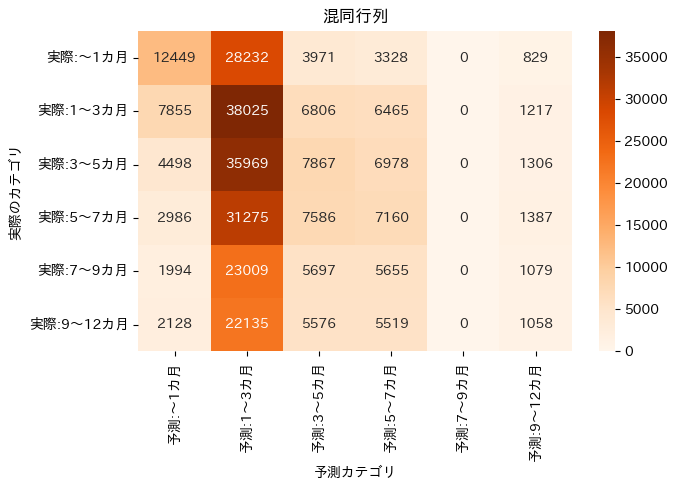

tensor([[0.1431, 0.3430, 0.5333, 0.7100, 0.8500],
        [0.1788, 0.4051, 0.5985, 0.7615, 0.8808],
        [0.1692, 0.3890, 0.5823, 0.7491, 0.8736],
        ...,
        [0.2155, 0.4620, 0.6528, 0.8010, 0.9031],
        [0.2115, 0.4561, 0.6474, 0.7972, 0.9010],
        [0.1399, 0.3372, 0.5269, 0.7046, 0.8466]])


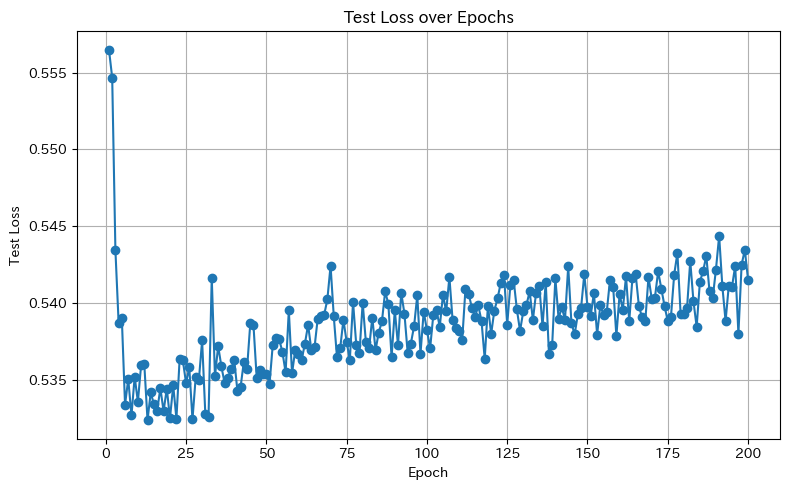

In [19]:
train_and_evaluate(X_train.values, Y_train.values, X_test.values, Y_test.values, num_classes=6, epochs=200)


Best Test MAE: 1.5949 at Epoch 61
Best Test MSE(When MAE is minimum): 4.3110
Best Test RMSE(When MAE is minimum): 2.0763
Best Test Accuracy(When MAE is minimum): 0.2299

Confusion Matrix(When MAE is minimum):
[[16528 28487  2438   920     0   436]
 [11156 42049  4618  2024     0   521]
 [ 6971 41541  5422  2197     0   487]
 [ 5121 36975  5476  2342     0   480]
 [ 3622 27377  4220  1881     0   334]
 [ 3788 26273  4159  1850     0   346]]

==== 混同行列 ====
           予測:～1カ月  予測:1〜3カ月  予測:3〜5カ月  予測:5〜7カ月  予測:7〜9カ月  予測:9〜12カ月
実際:～1カ月      16528     28487      2438       920         0        436
実際:1〜3カ月     11156     42049      4618      2024         0        521
実際:3〜5カ月      6971     41541      5422      2197         0        487
実際:5〜7カ月      5121     36975      5476      2342         0        480
実際:7〜9カ月      3622     27377      4220      1881         0        334
実際:9〜12カ月     3788     26273      4159      1850         0        346


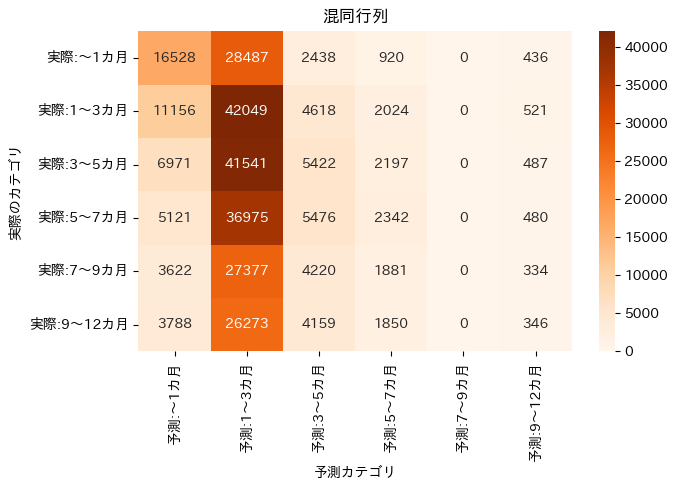

tensor([[0.1624, 0.3793, 0.5733, 0.7428, 0.8697],
        [0.2311, 0.4864, 0.6756, 0.8174, 0.9119],
        [0.1807, 0.4100, 0.6044, 0.7666, 0.8836],
        ...,
        [0.1702, 0.3927, 0.5871, 0.7534, 0.8760],
        [0.1683, 0.3893, 0.5837, 0.7508, 0.8745],
        [0.0998, 0.2588, 0.4344, 0.6227, 0.7923]])


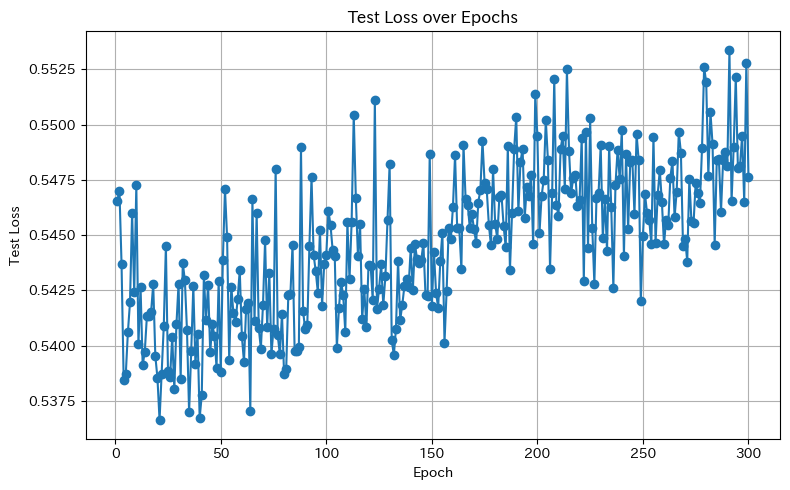

In [20]:
train_and_evaluate(X_train.values, Y_train.values, X_test.values, Y_test.values, num_classes=6, epochs=300)